In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import os
import yfinance as yf
warnings.filterwarnings('ignore')

In [26]:
class MAG7ValuationModel:
    """
    Comprehensive valuation model for Magnificent 7 companies using 5 key methods:
    1. Price-to-Earnings (P/E) Ratio
    2. Discounted Cash Flow (DCF)
    3. Price-to-Sales (P/S) Ratio
    4. Enterprise Value/EBITDA (EV/EBITDA)
    5. Price-to-Book (P/B) Ratio
    """
    
    def __init__(self):
        self.companies = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'TSLA', 'META']
        self.company_names = {
            'AAPL': 'Apple Inc.',
            'MSFT': 'Microsoft Corp.',
            'GOOGL': 'Alphabet Inc.',
            'AMZN': 'Amazon.com Inc.',
            'NVDA': 'NVIDIA Corp.',
            'TSLA': 'Tesla Inc.',
            'META': 'Meta Platforms Inc.'
        }
        
        # Fetch real-time financial data from yfinance
        print("Fetching real-time financial data from Yahoo Finance...")
        self.financial_data = self.fetch_financial_data()
    
    def fetch_financial_data(self):
        """Fetch real-time financial data from yfinance for all MAG7 companies"""
        financial_data = {}
        
        for ticker in self.companies:
            try:
                print(f"Fetching data for {ticker}...")
                stock = yf.Ticker(ticker)
                
                # Get basic info
                info = stock.info
                
                # Get financial statements
                financials = stock.financials
                balance_sheet = stock.balance_sheet
                cashflow = stock.cashflow
                
                # Current stock price
                current_price = info.get('currentPrice', info.get('regularMarketPrice', 0))
                
                # Market cap (in billions)
                market_cap = info.get('marketCap', 0) / 1e9 if info.get('marketCap') else 0
                
                # Shares outstanding (in billions)
                shares_outstanding = info.get('sharesOutstanding', 0) / 1e9 if info.get('sharesOutstanding') else 0
                
                # Revenue (TTM in billions) - Total Revenue from income statement
                revenue = 0
                if not financials.empty and 'Total Revenue' in financials.index:
                    revenue = financials.loc['Total Revenue'].iloc[0] / 1e9 if not pd.isna(financials.loc['Total Revenue'].iloc[0]) else 0
                
                # Net Income (TTM in billions)
                net_income = 0
                if not financials.empty and 'Net Income' in financials.index:
                    net_income = financials.loc['Net Income'].iloc[0] / 1e9 if not pd.isna(financials.loc['Net Income'].iloc[0]) else 0
                
                # EBITDA (TTM in billions)
                ebitda = info.get('ebitda', 0) / 1e9 if info.get('ebitda') else 0
                
                # Total debt (in billions)
                total_debt = 0
                if not balance_sheet.empty and 'Total Debt' in balance_sheet.index:
                    total_debt = balance_sheet.loc['Total Debt'].iloc[0] / 1e9 if not pd.isna(balance_sheet.loc['Total Debt'].iloc[0]) else 0
                elif not balance_sheet.empty and 'Long Term Debt' in balance_sheet.index:
                    # Fallback to long-term debt if total debt not available
                    long_term_debt = balance_sheet.loc['Long Term Debt'].iloc[0] / 1e9 if not pd.isna(balance_sheet.loc['Long Term Debt'].iloc[0]) else 0
                    current_debt = 0
                    if 'Current Debt' in balance_sheet.index:
                        current_debt = balance_sheet.loc['Current Debt'].iloc[0] / 1e9 if not pd.isna(balance_sheet.loc['Current Debt'].iloc[0]) else 0
                    total_debt = long_term_debt + current_debt
                
                # Cash and cash equivalents (in billions)
                cash = 0
                if not balance_sheet.empty and 'Cash And Cash Equivalents' in balance_sheet.index:
                    cash = balance_sheet.loc['Cash And Cash Equivalents'].iloc[0] / 1e9 if not pd.isna(balance_sheet.loc['Cash And Cash Equivalents'].iloc[0]) else 0
                elif not balance_sheet.empty and 'Cash' in balance_sheet.index:
                    cash = balance_sheet.loc['Cash'].iloc[0] / 1e9 if not pd.isna(balance_sheet.loc['Cash'].iloc[0]) else 0
                
                # Book value (Total Stockholder Equity in billions)
                book_value = 0
                if not balance_sheet.empty and 'Total Stockholder Equity' in balance_sheet.index:
                    book_value = balance_sheet.loc['Total Stockholder Equity'].iloc[0] / 1e9 if not pd.isna(balance_sheet.loc['Total Stockholder Equity'].iloc[0]) else 0
                elif not balance_sheet.empty and 'Stockholders Equity' in balance_sheet.index:
                    book_value = balance_sheet.loc['Stockholders Equity'].iloc[0] / 1e9 if not pd.isna(balance_sheet.loc['Stockholders Equity'].iloc[0]) else 0
                
                # Free Cash Flow (TTM in billions)
                free_cash_flow = 0
                if not cashflow.empty and 'Free Cash Flow' in cashflow.index:
                    free_cash_flow = cashflow.loc['Free Cash Flow'].iloc[0] / 1e9 if not pd.isna(cashflow.loc['Free Cash Flow'].iloc[0]) else 0
                elif not cashflow.empty and 'Operating Cash Flow' in cashflow.index and 'Capital Expenditures' in cashflow.index:
                    # Calculate FCF as Operating Cash Flow - Capital Expenditures
                    ocf = cashflow.loc['Operating Cash Flow'].iloc[0] / 1e9 if not pd.isna(cashflow.loc['Operating Cash Flow'].iloc[0]) else 0
                    capex = cashflow.loc['Capital Expenditures'].iloc[0] / 1e9 if not pd.isna(cashflow.loc['Capital Expenditures'].iloc[0]) else 0
                    free_cash_flow = ocf - abs(capex)  # capex is usually negative, so we take absolute value
                
                financial_data[ticker] = {
                    'market_cap': market_cap,
                    'revenue': revenue,
                    'net_income': net_income,
                    'ebitda': ebitda,
                    'total_debt': total_debt,
                    'cash': cash,
                    'book_value': book_value,
                    'shares_outstanding': shares_outstanding,
                    'free_cash_flow': free_cash_flow,
                    'current_price': current_price
                }
                
                print(f"✓ {ticker} data fetched successfully")
                
            except Exception as e:
                print(f"✗ Error fetching data for {ticker}: {str(e)}")
                # Provide fallback values to prevent crashes
                financial_data[ticker] = {
                    'market_cap': 0,
                    'revenue': 0,
                    'net_income': 0,
                    'ebitda': 0,
                    'total_debt': 0,
                    'cash': 0,
                    'book_value': 0,
                    'shares_outstanding': 1,  # Avoid division by zero
                    'free_cash_flow': 0,
                    'current_price': 0
                }
        
        print("Data fetching completed!\n")
        return financial_data
    
    def calculate_pe_valuation(self):
        """Calculate P/E ratio and implied valuations"""
        pe_data = {}
        
        for ticker in self.companies:
            data = self.financial_data[ticker]
            eps = data['net_income'] / data['shares_outstanding']
            pe_ratio = data['current_price'] / eps if eps > 0 else np.nan
            
            pe_data[ticker] = {
                'eps': eps,
                'pe_ratio': pe_ratio,
                'current_price': data['current_price']
            }
        
        return pe_data
    
    def calculate_dcf_valuation(self, growth_rate=0.08, terminal_growth=0.03, discount_rate=0.10, years=5):
        """Calculate DCF valuation using free cash flow projections"""
        dcf_data = {}
        
        for ticker in self.companies:
            data = self.financial_data[ticker]
            fcf = data['free_cash_flow']
            shares = data['shares_outstanding']
            
            # Project future cash flows
            future_fcf = []
            for year in range(1, years + 1):
                projected_fcf = fcf * (1 + growth_rate) ** year
                future_fcf.append(projected_fcf)
            
            # Terminal value
            terminal_fcf = future_fcf[-1] * (1 + terminal_growth)
            terminal_value = terminal_fcf / (discount_rate - terminal_growth)
            
            # Discount to present value
            pv_fcf = sum([cf / (1 + discount_rate) ** (i + 1) for i, cf in enumerate(future_fcf)])
            pv_terminal = terminal_value / (1 + discount_rate) ** years
            
            enterprise_value = pv_fcf + pv_terminal
            equity_value = enterprise_value + data['cash'] - data['total_debt']
            dcf_price = equity_value / shares
            
            dcf_data[ticker] = {
                'dcf_price': dcf_price,
                'enterprise_value': enterprise_value,
                'equity_value': equity_value,
                'current_price': data['current_price']
            }
        
        return dcf_data
    
    def calculate_ps_valuation(self):
        """Calculate Price-to-Sales ratio and sector comparison"""
        ps_data = {}
        
        for ticker in self.companies:
            data = self.financial_data[ticker]
            revenue_per_share = data['revenue'] / data['shares_outstanding']
            ps_ratio = data['current_price'] / revenue_per_share
            
            ps_data[ticker] = {
                'revenue_per_share': revenue_per_share,
                'ps_ratio': ps_ratio,
                'current_price': data['current_price']
            }
        
        return ps_data
    
    def calculate_ev_ebitda_valuation(self):
        """Calculate EV/EBITDA ratio"""
        ev_ebitda_data = {}
        
        for ticker in self.companies:
            data = self.financial_data[ticker]
            enterprise_value = data['market_cap'] + data['total_debt'] - data['cash']
            ev_ebitda_ratio = enterprise_value / data['ebitda'] if data['ebitda'] > 0 else np.nan
            
            ev_ebitda_data[ticker] = {
                'enterprise_value': enterprise_value,
                'ebitda': data['ebitda'],
                'ev_ebitda_ratio': ev_ebitda_ratio,
                'market_cap': data['market_cap']
            }
        
        return ev_ebitda_data
    
    def calculate_pb_valuation(self):
        """Calculate Price-to-Book ratio"""
        pb_data = {}
        
        for ticker in self.companies:
            data = self.financial_data[ticker]
            book_value_per_share = data['book_value'] / data['shares_outstanding']
            pb_ratio = data['current_price'] / book_value_per_share
            
            pb_data[ticker] = {
                'book_value_per_share': book_value_per_share,
                'pb_ratio': pb_ratio,
                'current_price': data['current_price']
            }
        
        return pb_data
    
    def comprehensive_analysis(self):
        """Perform comprehensive valuation analysis"""
        pe_data = self.calculate_pe_valuation()
        dcf_data = self.calculate_dcf_valuation()
        ps_data = self.calculate_ps_valuation()
        ev_ebitda_data = self.calculate_ev_ebitda_valuation()
        pb_data = self.calculate_pb_valuation()
        
        # Create summary DataFrame
        summary_data = []
        
        for ticker in self.companies:
            row = {
                'Company': self.company_names[ticker],
                'Ticker': ticker,
                'Current Price': self.financial_data[ticker]['current_price'],
                'Market Cap (B)': self.financial_data[ticker]['market_cap'],
                'P/E Ratio': pe_data[ticker]['pe_ratio'],
                'DCF Price': dcf_data[ticker]['dcf_price'],
                'P/S Ratio': ps_data[ticker]['ps_ratio'],
                'EV/EBITDA': ev_ebitda_data[ticker]['ev_ebitda_ratio'],
                'P/B Ratio': pb_data[ticker]['pb_ratio']
            }
            summary_data.append(row)
        
        summary_df = pd.DataFrame(summary_data)
        
        return summary_df, pe_data, dcf_data, ps_data, ev_ebitda_data, pb_data
    
    def calculate_relative_valuations(self, summary_df):
        """Calculate relative valuations based on sector averages"""
        # Calculate sector averages (excluding outliers)
        metrics = ['P/E Ratio', 'P/S Ratio', 'EV/EBITDA', 'P/B Ratio']
        sector_averages = {}
        
        for metric in metrics:
            values = summary_df[metric].dropna()
            # Remove extreme outliers (beyond 2 standard deviations)
            mean_val = values.mean()
            std_val = values.std()
            filtered_values = values[(values >= mean_val - 2*std_val) & (values <= mean_val + 2*std_val)]
            sector_averages[metric] = filtered_values.mean()
        
        # Calculate implied prices based on sector averages
        relative_valuations = []
        
        for _, row in summary_df.iterrows():
            ticker = row['Ticker']
            data = self.financial_data[ticker]
            
            # P/E based valuation
            eps = data['net_income'] / data['shares_outstanding']
            pe_implied_price = eps * sector_averages['P/E Ratio'] if not np.isnan(sector_averages['P/E Ratio']) else np.nan
            
            # P/S based valuation
            revenue_per_share = data['revenue'] / data['shares_outstanding']
            ps_implied_price = revenue_per_share * sector_averages['P/S Ratio']
            
            # P/B based valuation
            book_value_per_share = data['book_value'] / data['shares_outstanding']
            pb_implied_price = book_value_per_share * sector_averages['P/B Ratio']
            
            relative_valuations.append({
                'Ticker': ticker,
                'Company': row['Company'],
                'Current Price': row['Current Price'],
                'PE Implied Price': pe_implied_price,
                'PS Implied Price': ps_implied_price,
                'PB Implied Price': pb_implied_price,
                'DCF Price': row['DCF Price']
            })
        
        return pd.DataFrame(relative_valuations), sector_averages
    
    def visualize_analysis(self, summary_df, relative_valuations_df, save_figures=True, output_dir="mag7_analysis_charts"):
        """Create comprehensive visualization of the analysis"""
        import os
        
        # Create output directory if saving figures
        if save_figures:
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)
            print(f"Saving charts to directory: {output_dir}/")
        
        fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        fig.suptitle('MAG7 Comprehensive Valuation Analysis', fontsize=16, fontweight='bold')
        
        # 1. Market Cap comparison
        axes[0, 0].bar(summary_df['Ticker'], summary_df['Market Cap (B)'])
        axes[0, 0].set_title('Market Capitalization (Billions)')
        axes[0, 0].set_ylabel('Market Cap ($B)')
        axes[0, 0].tick_params(axis='x', rotation=45)
        
        # 2. P/E Ratio comparison
        pe_data = summary_df[summary_df['P/E Ratio'].notna()]
        axes[0, 1].bar(pe_data['Ticker'], pe_data['P/E Ratio'], color='orange')
        axes[0, 1].set_title('Price-to-Earnings Ratio')
        axes[0, 1].set_ylabel('P/E Ratio')
        axes[0, 1].tick_params(axis='x', rotation=45)
        
        # 3. DCF vs Current Price
        axes[0, 2].scatter(relative_valuations_df['Current Price'], relative_valuations_df['DCF Price'], s=100)
        axes[0, 2].plot([0, max(relative_valuations_df['Current Price'])], 
                       [0, max(relative_valuations_df['Current Price'])], 'r--', alpha=0.7)
        axes[0, 2].set_xlabel('Current Price')
        axes[0, 2].set_ylabel('DCF Price')
        axes[0, 2].set_title('DCF vs Current Price')
        
        # Add company labels
        for i, row in relative_valuations_df.iterrows():
            axes[0, 2].annotate(row['Ticker'], 
                              (row['Current Price'], row['DCF Price']),
                              xytext=(5, 5), textcoords='offset points', fontsize=8)
        
        # 4. Valuation Multiples Heatmap
        multiples_data = summary_df[['Ticker', 'P/E Ratio', 'P/S Ratio', 'EV/EBITDA', 'P/B Ratio']].set_index('Ticker')
        im = axes[1, 0].imshow(multiples_data.T, cmap='RdYlBu_r', aspect='auto')
        axes[1, 0].set_xticks(range(len(multiples_data.index)))
        axes[1, 0].set_xticklabels(multiples_data.index)
        axes[1, 0].set_yticks(range(len(multiples_data.columns)))
        axes[1, 0].set_yticklabels(multiples_data.columns)
        axes[1, 0].set_title('Valuation Multiples Heatmap')
        plt.colorbar(im, ax=axes[1, 0])
        
        # 5. Price Comparison (Current vs Implied)
        price_comparison = relative_valuations_df[['Ticker', 'Current Price', 'PE Implied Price', 
                                                 'PS Implied Price', 'PB Implied Price', 'DCF Price']]
        price_comparison_clean = price_comparison.set_index('Ticker').fillna(0)
        
        x = np.arange(len(price_comparison_clean.index))
        width = 0.15
        
        axes[1, 1].bar(x - 2*width, price_comparison_clean['Current Price'], width, label='Current Price')
        axes[1, 1].bar(x - width, price_comparison_clean['PE Implied Price'], width, label='PE Implied')
        axes[1, 1].bar(x, price_comparison_clean['PS Implied Price'], width, label='PS Implied')
        axes[1, 1].bar(x + width, price_comparison_clean['PB Implied Price'], width, label='PB Implied')
        axes[1, 1].bar(x + 2*width, price_comparison_clean['DCF Price'], width, label='DCF Price')
        
        axes[1, 1].set_xlabel('Companies')
        axes[1, 1].set_ylabel('Price ($)')
        axes[1, 1].set_title('Price Comparison: Current vs Implied Valuations')
        axes[1, 1].set_xticks(x)
        axes[1, 1].set_xticklabels(price_comparison_clean.index, rotation=45)
        axes[1, 1].legend()
        
        # 6. Premium/Discount Analysis
        premium_discount = []
        for _, row in relative_valuations_df.iterrows():
            current = row['Current Price']
            dcf = row['DCF Price']
            pe_implied = row['PE Implied Price']
            
            dcf_premium = ((current - dcf) / dcf * 100) if not np.isnan(dcf) else 0
            pe_premium = ((current - pe_implied) / pe_implied * 100) if not np.isnan(pe_implied) else 0
            
            premium_discount.append({
                'Ticker': row['Ticker'],
                'DCF Premium/Discount (%)': dcf_premium,
                'PE Premium/Discount (%)': pe_premium
            })
        
        premium_df = pd.DataFrame(premium_discount)
        
        x = np.arange(len(premium_df))
        width = 0.35
        
        axes[1, 2].bar(x - width/2, premium_df['DCF Premium/Discount (%)'], width, 
                      label='DCF Premium/Discount', alpha=0.8)
        axes[1, 2].bar(x + width/2, premium_df['PE Premium/Discount (%)'], width, 
                      label='PE Premium/Discount', alpha=0.8)
        axes[1, 2].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        axes[1, 2].set_xlabel('Companies')
        axes[1, 2].set_ylabel('Premium/Discount (%)')
        axes[1, 2].set_title('Valuation Premium/Discount Analysis')
        axes[1, 2].set_xticks(x)
        axes[1, 2].set_xticklabels(premium_df['Ticker'], rotation=45)
        axes[1, 2].legend()
        
        plt.tight_layout()
        
        # Save the comprehensive figure
        if save_figures:
            comprehensive_path = os.path.join(output_dir, "01_comprehensive_analysis.png")
            plt.savefig(comprehensive_path, dpi=300, bbox_inches='tight', facecolor='white')
            print(f"✓ Saved: {comprehensive_path}")
        
        plt.show()
        
        # Create and save individual charts for better clarity
        if save_figures:
            self._save_individual_charts(summary_df, relative_valuations_df, output_dir)
    
    def _save_individual_charts(self, summary_df, relative_valuations_df, output_dir):
        """Create and save individual charts as separate PNG files"""
        
        # 1. Market Cap Chart
        plt.figure(figsize=(12, 6))
        bars = plt.bar(summary_df['Ticker'], summary_df['Market Cap (B)'], 
                      color='steelblue', alpha=0.8)
        plt.title('MAG7 Market Capitalization Comparison', fontsize=14, fontweight='bold')
        plt.ylabel('Market Cap (Billions USD)', fontsize=12)
        plt.xlabel('Companies', fontsize=12)
        plt.xticks(rotation=45)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                    f'${height:.0f}B', ha='center', va='bottom', fontsize=10)
        
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        market_cap_path = os.path.join(output_dir, "02_market_cap_comparison.png")
        plt.savefig(market_cap_path, dpi=300, bbox_inches='tight', facecolor='white')
        plt.close()
        print(f"✓ Saved: {market_cap_path}")
        
        # 2. P/E Ratio Chart
        pe_data = summary_df[summary_df['P/E Ratio'].notna()]
        if not pe_data.empty:
            plt.figure(figsize=(12, 6))
            bars = plt.bar(pe_data['Ticker'], pe_data['P/E Ratio'], 
                          color='orange', alpha=0.8)
            plt.title('MAG7 Price-to-Earnings Ratio Comparison', fontsize=14, fontweight='bold')
            plt.ylabel('P/E Ratio', fontsize=12)
            plt.xlabel('Companies', fontsize=12)
            plt.xticks(rotation=45)
            
            # Add value labels
            for bar in bars:
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                        f'{height:.1f}', ha='center', va='bottom', fontsize=10)
            
            plt.grid(axis='y', alpha=0.3)
            plt.tight_layout()
            pe_path = os.path.join(output_dir, "03_pe_ratio_comparison.png")
            plt.savefig(pe_path, dpi=300, bbox_inches='tight', facecolor='white')
            plt.close()
            print(f"✓ Saved: {pe_path}")
        
        # 3. DCF vs Current Price Scatter Plot
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(relative_valuations_df['Current Price'], 
                            relative_valuations_df['DCF Price'], 
                            s=150, alpha=0.7, c='red')
        
        # Perfect valuation line (where DCF = Current Price)
        max_price = max(relative_valuations_df['Current Price'].max(), 
                       relative_valuations_df['DCF Price'].max())
        plt.plot([0, max_price], [0, max_price], 'k--', alpha=0.7, linewidth=2, 
                label='Perfect Valuation Line')
        
        plt.xlabel('Current Market Price ($)', fontsize=12)
        plt.ylabel('DCF Intrinsic Value ($)', fontsize=12)
        plt.title('DCF Valuation vs Current Market Price', fontsize=14, fontweight='bold')
        
        # Add company labels
        for i, row in relative_valuations_df.iterrows():
            plt.annotate(row['Ticker'], 
                        (row['Current Price'], row['DCF Price']),
                        xytext=(8, 8), textcoords='offset points', 
                        fontsize=10, fontweight='bold')
        
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        dcf_path = os.path.join(output_dir, "04_dcf_vs_current_price.png")
        plt.savefig(dcf_path, dpi=300, bbox_inches='tight', facecolor='white')
        plt.close()
        print(f"✓ Saved: {dcf_path}")
        
        # 4. Valuation Methods Comparison
        plt.figure(figsize=(14, 8))
        price_comparison = relative_valuations_df[['Ticker', 'Current Price', 'PE Implied Price', 
                                                 'PS Implied Price', 'PB Implied Price', 'DCF Price']]
        price_comparison_clean = price_comparison.set_index('Ticker').fillna(0)
        
        x = np.arange(len(price_comparison_clean.index))
        width = 0.15
        
        plt.bar(x - 2*width, price_comparison_clean['Current Price'], width, 
               label='Current Price', alpha=0.8, color='blue')
        plt.bar(x - width, price_comparison_clean['PE Implied Price'], width, 
               label='PE Implied', alpha=0.8, color='orange')
        plt.bar(x, price_comparison_clean['PS Implied Price'], width, 
               label='PS Implied', alpha=0.8, color='green')
        plt.bar(x + width, price_comparison_clean['PB Implied Price'], width, 
               label='PB Implied', alpha=0.8, color='red')
        plt.bar(x + 2*width, price_comparison_clean['DCF Price'], width, 
               label='DCF Price', alpha=0.8, color='purple')
        
        plt.xlabel('Companies', fontsize=12)
        plt.ylabel('Price ($)', fontsize=12)
        plt.title('Valuation Methods Comparison: Current vs Implied Prices', fontsize=14, fontweight='bold')
        plt.xticks(x, price_comparison_clean.index, rotation=45)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        methods_path = os.path.join(output_dir, "05_valuation_methods_comparison.png")
        plt.savefig(methods_path, dpi=300, bbox_inches='tight', facecolor='white')
        plt.close()
        print(f"✓ Saved: {methods_path}")
        
        # 5. Premium/Discount Analysis
        premium_discount = []
        for _, row in relative_valuations_df.iterrows():
            current = row['Current Price']
            dcf = row['DCF Price']
            pe_implied = row['PE Implied Price']
            
            dcf_premium = ((current - dcf) / dcf * 100) if not np.isnan(dcf) and dcf != 0 else 0
            pe_premium = ((current - pe_implied) / pe_implied * 100) if not np.isnan(pe_implied) and pe_implied != 0 else 0
            
            premium_discount.append({
                'Ticker': row['Ticker'],
                'DCF Premium/Discount (%)': dcf_premium,
                'PE Premium/Discount (%)': pe_premium
            })
        
        premium_df = pd.DataFrame(premium_discount)
        
        plt.figure(figsize=(12, 6))
        x = np.arange(len(premium_df))
        width = 0.35
        
        bars1 = plt.bar(x - width/2, premium_df['DCF Premium/Discount (%)'], width, 
                       label='DCF Premium/Discount (%)', alpha=0.8, color='darkblue')
        bars2 = plt.bar(x + width/2, premium_df['PE Premium/Discount (%)'], width, 
                       label='PE Premium/Discount (%)', alpha=0.8, color='darkred')
        
        plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
        plt.xlabel('Companies', fontsize=12)
        plt.ylabel('Premium/Discount (%)', fontsize=12)
        plt.title('Valuation Premium/Discount Analysis', fontsize=14, fontweight='bold')
        plt.xticks(x, premium_df['Ticker'], rotation=45)
        plt.legend()
        plt.grid(axis='y', alpha=0.3)
        
        # Add value labels on bars
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2., height + (1 if height >= 0 else -3),
                        f'{height:.1f}%', ha='center', va='bottom' if height >= 0 else 'top', 
                        fontsize=9)
        
        plt.tight_layout()
        premium_path = os.path.join(output_dir, "06_premium_discount_analysis.png")
        plt.savefig(premium_path, dpi=300, bbox_inches='tight', facecolor='white')
        plt.close()
        print(f"✓ Saved: {premium_path}")
        
        # 6. Financial Metrics Heatmap
        plt.figure(figsize=(12, 8))
        multiples_data = summary_df[['Ticker', 'P/E Ratio', 'P/S Ratio', 'EV/EBITDA', 'P/B Ratio']].set_index('Ticker')
        
        # Create heatmap
        sns.heatmap(multiples_data.T, annot=True, cmap='RdYlBu_r', 
                   fmt='.1f', cbar_kws={'label': 'Ratio Value'})
        plt.title('MAG7 Valuation Multiples Heatmap', fontsize=14, fontweight='bold')
        plt.ylabel('Valuation Metrics', fontsize=12)
        plt.xlabel('Companies', fontsize=12)
        plt.tight_layout()
        heatmap_path = os.path.join(output_dir, "07_valuation_multiples_heatmap.png")
        plt.savefig(heatmap_path, dpi=300, bbox_inches='tight', facecolor='white')
        plt.close()
        print(f"✓ Saved: {heatmap_path}")
        
        print(f"\n📁 All charts saved successfully in '{output_dir}/' directory!")
        print("📊 Individual charts created for:")
        print("   • Market Cap Comparison")
        print("   • P/E Ratio Analysis") 
        print("   • DCF vs Current Price")
        print("   • Valuation Methods Comparison")
        print("   • Premium/Discount Analysis")
        print("   • Valuation Multiples Heatmap")

MAG7 COMPREHENSIVE VALUATION ANALYSIS (REAL-TIME DATA)
Fetching real-time financial data from Yahoo Finance...
Fetching data for AAPL...
✓ AAPL data fetched successfully
Fetching data for MSFT...
✓ MSFT data fetched successfully
Fetching data for GOOGL...
✓ GOOGL data fetched successfully
Fetching data for AMZN...
✓ AMZN data fetched successfully
Fetching data for NVDA...
✓ NVDA data fetched successfully
Fetching data for TSLA...
✓ TSLA data fetched successfully
Fetching data for META...
✓ META data fetched successfully
Data fetching completed!

FETCHED FINANCIAL DATA SUMMARY
----------------------------------------
AAPL: Market Cap: $2993.4B, Price: $200.42
MSFT: Market Cap: $3399.3B, Price: $457.36
GOOGL: Market Cap: $2097.4B, Price: $172.36
AMZN: Market Cap: $2173.4B, Price: $204.72
NVDA: Market Cap: $3287.7B, Price: $134.81
TSLA: Market Cap: $1149.6B, Price: $356.90
META: Market Cap: $1618.2B, Price: $643.58

1. SUMMARY VALUATION METRICS
--------------------------------------------

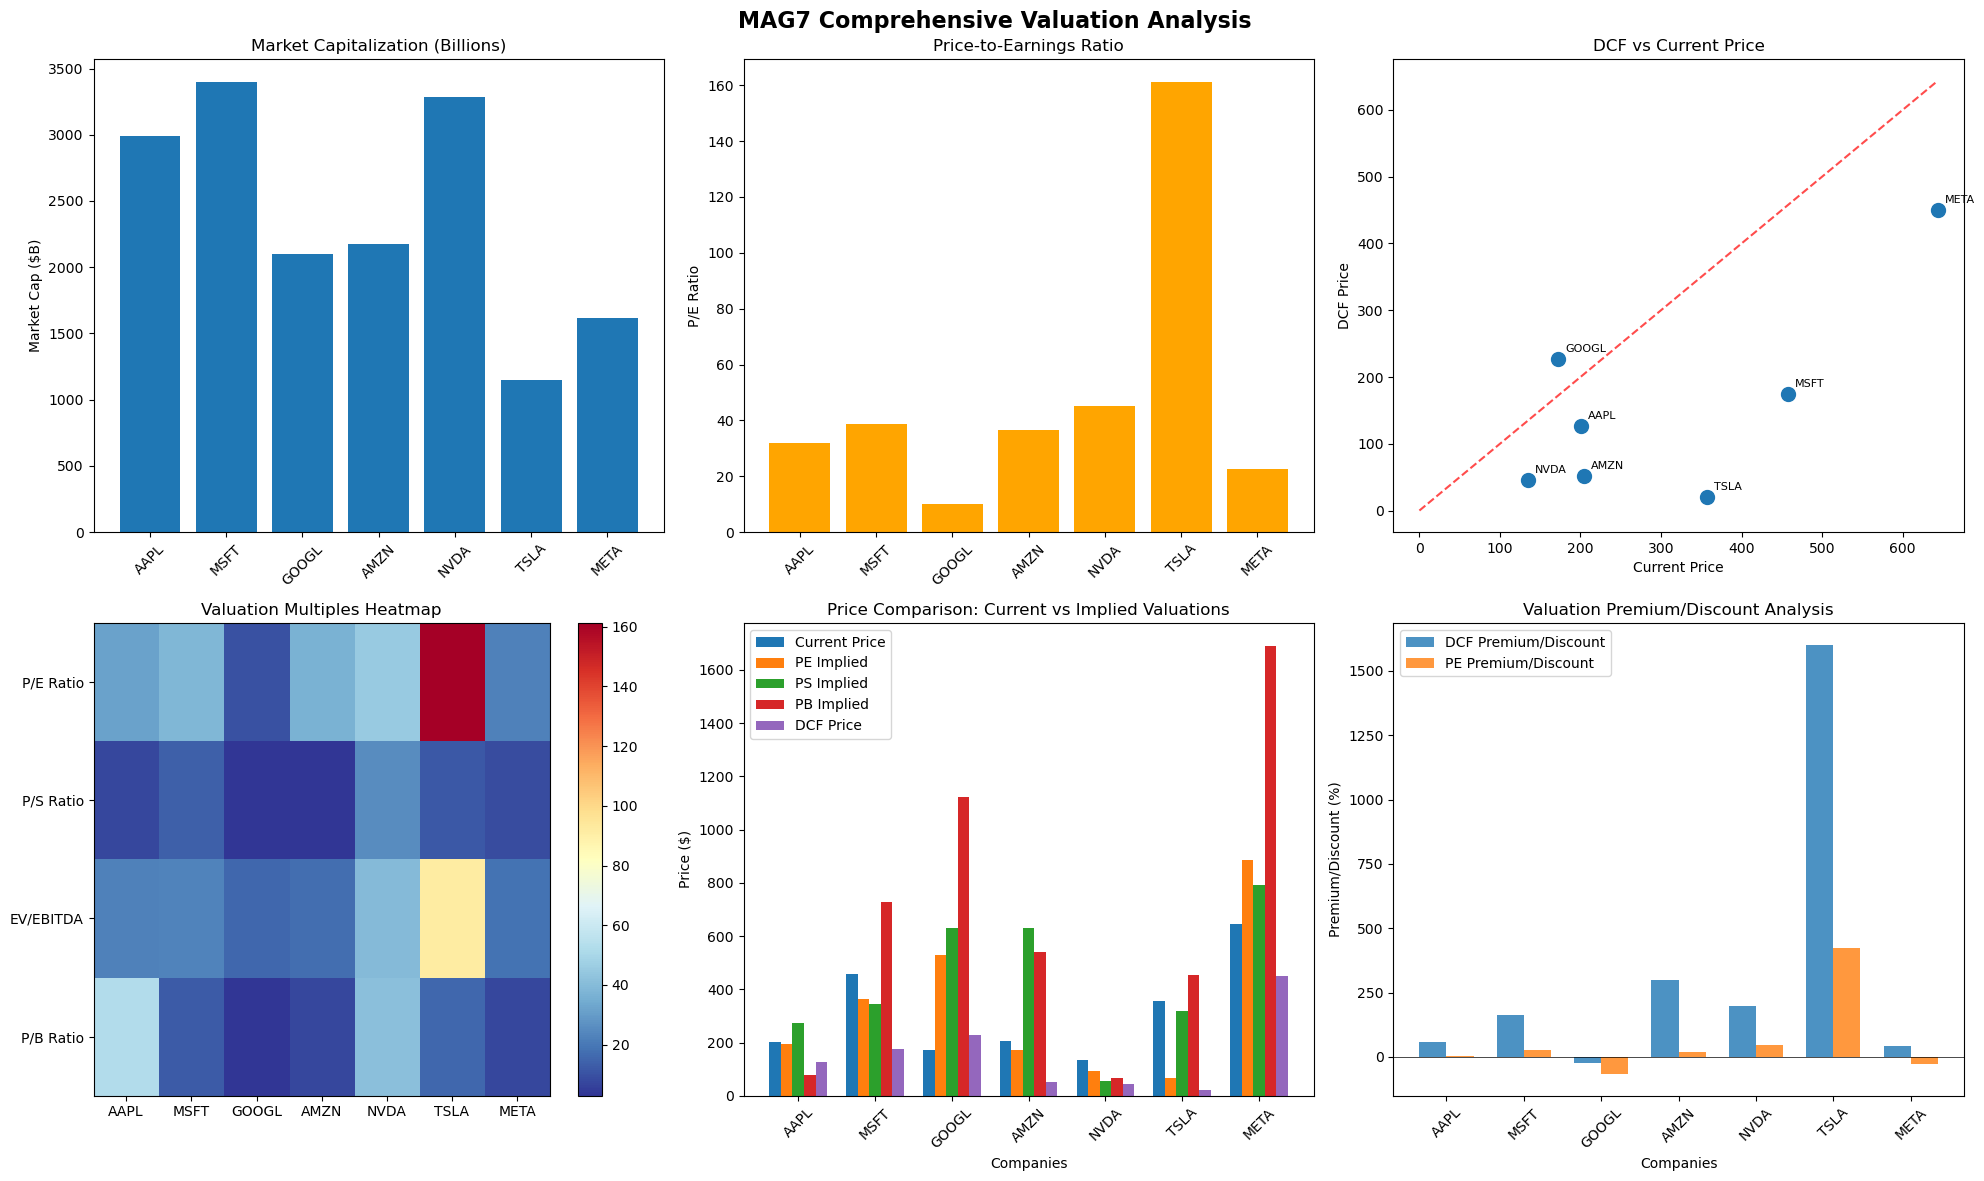

✓ Saved: mag7_analysis_charts/02_market_cap_comparison.png
✓ Saved: mag7_analysis_charts/03_pe_ratio_comparison.png
✓ Saved: mag7_analysis_charts/04_dcf_vs_current_price.png
✓ Saved: mag7_analysis_charts/05_valuation_methods_comparison.png
✓ Saved: mag7_analysis_charts/06_premium_discount_analysis.png
✓ Saved: mag7_analysis_charts/07_valuation_multiples_heatmap.png

📁 All charts saved successfully in 'mag7_analysis_charts/' directory!
📊 Individual charts created for:
   • Market Cap Comparison
   • P/E Ratio Analysis
   • DCF vs Current Price
   • Valuation Methods Comparison
   • Premium/Discount Analysis
   • Valuation Multiples Heatmap


In [28]:
def run_mag7_analysis():
    """Run the complete MAG7 valuation analysis with real-time data"""
    
    print("="*80)
    print("MAG7 COMPREHENSIVE VALUATION ANALYSIS (REAL-TIME DATA)")
    print("="*80)
    
    # Initialize the model (this will fetch real-time data)
    model = MAG7ValuationModel()
    
    # Display fetched data summary
    print("FETCHED FINANCIAL DATA SUMMARY")
    print("-" * 40)
    for ticker in model.companies:
        data = model.financial_data[ticker]
        print(f"{ticker}: Market Cap: ${data['market_cap']:.1f}B, Price: ${data['current_price']:.2f}")
    
    # Perform comprehensive analysis
    summary_df, pe_data, dcf_data, ps_data, ev_ebitda_data, pb_data = model.comprehensive_analysis()
    
    # Calculate relative valuations
    relative_valuations_df, sector_averages = model.calculate_relative_valuations(summary_df)
    
    # Display results
    print("\n1. SUMMARY VALUATION METRICS")
    print("-" * 50)
    print(summary_df.round(2).to_string(index=False))
    
    print(f"\n\n2. SECTOR AVERAGE MULTIPLES")
    print("-" * 30)
    for metric, avg in sector_averages.items():
        print(f"{metric}: {avg:.2f}")
    
    print(f"\n\n3. RELATIVE VALUATION ANALYSIS")
    print("-" * 40)
    print(relative_valuations_df.round(2).to_string(index=False))
    
    # Key insights
    print(f"\n\n4. KEY INSIGHTS")
    print("-" * 20)
    
    # Find most expensive and cheapest by P/E
    pe_valid = summary_df[summary_df['P/E Ratio'].notna()]
    if not pe_valid.empty:
        highest_pe = pe_valid.loc[pe_valid['P/E Ratio'].idxmax()]
        lowest_pe = pe_valid.loc[pe_valid['P/E Ratio'].idxmin()]
        print(f"• Highest P/E: {highest_pe['Company']} ({highest_pe['P/E Ratio']:.1f})")
        print(f"• Lowest P/E: {lowest_pe['Company']} ({lowest_pe['P/E Ratio']:.1f})")
    
    # DCF Analysis
    dcf_undervalued = relative_valuations_df[relative_valuations_df['DCF Price'] > relative_valuations_df['Current Price']]
    dcf_overvalued = relative_valuations_df[relative_valuations_df['DCF Price'] < relative_valuations_df['Current Price']]
    
    print(f"\n• DCF Analysis:")
    if not dcf_undervalued.empty:
        print(f"  - Potentially Undervalued: {', '.join(dcf_undervalued['Ticker'].tolist())}")
    if not dcf_overvalued.empty:
        print(f"  - Potentially Overvalued: {', '.join(dcf_overvalued['Ticker'].tolist())}")
    
    # Market cap leaders
    largest_company = summary_df.loc[summary_df['Market Cap (B)'].idxmax()]
    print(f"\n• Market Cap Leader: {largest_company['Company']} (${largest_company['Market Cap (B)']}B)")
    
    # Data freshness note
    print(f"\n• Data Source: Yahoo Finance (Real-time)")
    print(f"• Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    
    # Create visualizations
    print(f"\n\n5. GENERATING VISUALIZATIONS...")
    print("-" * 35)
    model.visualize_analysis(summary_df, relative_valuations_df, save_figures=True)
    
    return model, summary_df, relative_valuations_df

# Run the analysis
if __name__ == "__main__":
    model, summary_df, relative_valuations_df = run_mag7_analysis()